In [1]:
#Create data set
import glob
import pandas as pd
import re
import spacy
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))

numdocs = 50 #nuber of documents to be processed
path = '/home/tobias/Documents/RobotJudge/cases/' #path to the case files



cases = []
years = []
ids = []

nlp = spacy.load('en')
files = glob.glob(path + '*.txt')
i = 0


for file in files:
    if i > numdocs:
        break
    try:
        with open(file) as open_file:
            cases.append(open_file.read())
            years.append(re.findall(path + '(\d+)', file)[0])
            id = re.findall(path + '(\d+)_(\S)(\S)(\S)(\S)(\S)(\S)', file)[0]
            ids.append(''.join(id[1:7]))
            i += 1
    except:
            print("Error reading File")    
            
df  = pd.DataFrame({'caseid':ids,'text':cases, 'year':years})

def runSpacy(txt):
    return nlp(txt)

df['doc'] = df['text'].apply(runSpacy)


Error reading File
Error reading File
Error reading File


In [2]:
def normalize(doc): 
    sents = []
    for sent in doc.sents:
        sent = str(sent)
        sent = sent.replace('\r', ' ').replace('\n', ' ')
        lower = sent.lower() # all lower case
        nopunc = lower.translate(translator) # remove punctuation       
        words = nopunc.split() # split into tokens
        nostop = [w for w in words if w not in stoplist] # remove stopwords
        no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
        stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
        tokens = []
        for i in stemmed:
            if len(i) > 1 and not any(char.isdigit() for char in i):
                tokens.append(i)
                
        sents.append(tokens)
    return sents
df['cleanSents'] = df['doc'].apply(normalize)
df.head()

,caseid,text,year,doc,cleanSents
0,X21KR0,PER CURIAM.\nThe sole question in this case i...,1962,"( , PER, CURIAM, ., \n, The, sole, question, i...","[[per, curiam], [sole, question, case, whether..."
1,X2NJD6,"MYRON L. GORDON, District Judge.\nThis is an ...",1973,"( , MYRON, L., GORDON, ,, District, Judge, ., ...","[[myron, gordon, district, judg], [interlocuto..."
2,X40B69,"WILBUR , Circuit Judge.\nThese two petitions ...",1941,"( , WILBUR, ,, Circuit, Judge, ., \n, These, t...","[[wilbur, circuit, judg], [two, petit, review,..."
3,X9VH38,"PER CURIAM.\nDefendant, convicted of selling ...",1965,"( , PER, CURIAM, ., \n, Defendant, ,, convicte...","[[per, curiam], [defend, convict, sell, marihu..."
4,XABN4A,"GOLDBERG , Circuit Judge: The segregation of ...",1984,"( , GOLDBERG, ,, Circuit, Judge, :, The, segre...","[[goldberg, circuit, judg], [segreg, one, grou..."


In [3]:
#Problem 1
#create sentences for w2v
sentences = []

def retsent(sents):
    for i in sents:
        sentences.append(i)
        
df['cleanSents'].apply(retsent)

from random import shuffle
shuffle(sentences) # stream in sentences in random order

sentences

[['led'],
 ['appli',
  'civil',
  'practic',
  'act',
  'new',
  'york',
  'court',
  'would',
  'take',
  'account',
  'oneyear',
  'limit',
  'california',
  'applic',
  'action',
  'wrong',
  'death',
  'accouter',
  'includ',
  'provis',
  'toll',
  'statut',
  'minor'],
 ['appeal',
  'present',
  'narrow',
  'issu',
  'age',
  'discrimin',
  'employ',
  'act',
  'usc',
  'et',
  'seq'],
 [],
 ['tax', 'paid', 'action', 'brought', 'recov'],
 ['stockbrok',
  'becom',
  'purchas',
  'stock',
  'owner',
  'request',
  'broker',
  'sell',
  'certain',
  'owner',
  'secur'],
 ['stat'],
 ['condit',
  'bodi',
  'mind',
  'natur',
  'give',
  'rise',
  'feel',
  'death',
  'near',
  'donor',
  'reach',
  'moment',
  'inevit',
  'surrend',
  'ownership',
  'like',
  'prompt',
  'disposit',
  'deem',
  'proper',
  'object',
  'bounti',
  'evid',
  'exist',
  'nonexist',
  'condit',
  'time',
  'gift',
  'obvious',
  'great',
  'import',
  'determin',
  'whether',
  'made',
  'contempl',
  'de

In [6]:
# train the two different models
from gensim.models import Word2Vec
w2v = Word2Vec(sentences,  # list of tokenized sentences
               workers = 8, # Number of threads to run in parallel
               size=300,  # Word vector dimensionality     
               min_count =  25, # Minimum word count  
               window = 2, # Context window size      
               sample = 1e-3, # Downsample setting for frequent words
               )

# done training, so delete context vectors
w2v.init_sims(replace=True)

w2v15 = Word2Vec(sentences,  # list of tokenized sentences
               workers = 8, # Number of threads to run in parallel
               size=300,  # Word vector dimensionality     
               min_count =  25, # Minimum word count  
               window = 15, # Context window size      
               sample = 1e-3, # Downsample setting for frequent words
               )

# done training, so delete context vectors
w2v15.init_sims(replace=True)


w2v.wv['rule']


767

In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
vocab = list(w2v.wv.vocab)
X = w2v[vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

dfw2v = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

dfw2v['word'] = vocab

dfw2v.head()




vocab15 = list(w2v15.wv.vocab)
X15 = w2v15[vocab]

tsne15 = TSNE(n_components=2)
X_tsne15 = tsne15.fit_transform(X15)

dfw2v15 = pd.DataFrame(X_tsne15, index=vocab, columns=['x', 'y'])

dfw2v15['word'] = vocab15

dfw2v15.head()


/home/tobias/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/home/tobias/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


,x,y,word
led,-17.637434,26.337292,led
appli,-13.736719,8.623727,appli
civil,5.416469,20.295626,civil
practic,-8.612268,-6.212468,practic
act,27.577450,4.309139,act


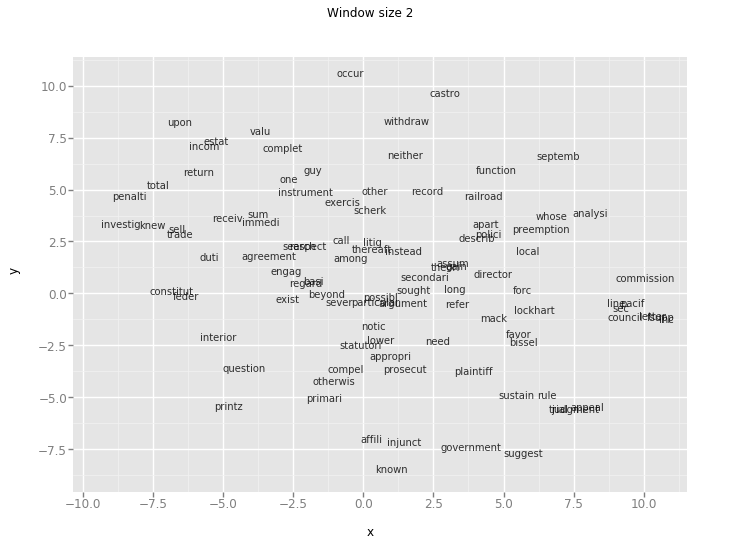

In [15]:
dfw2v100 = dfw2v.sample(100)

import ggplot as gg
chart = gg.ggplot( dfw2v100, gg.aes(x='x', y='y', label='word') ) \
                      + gg.geom_text(size=10, alpha=.8, label='word') 
chart.title = 'Window size 2'
chart.show()

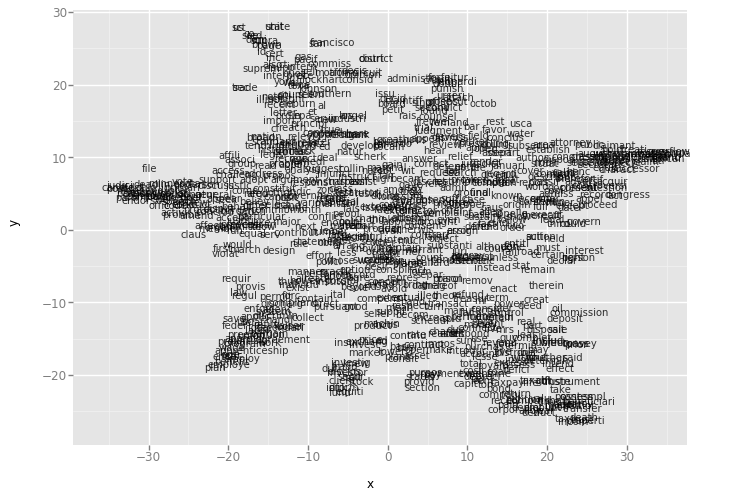

In [16]:
dfw2v15100 = dfw2v15.sample(100)

chart15 = gg.ggplot( dfw2v15, gg.aes(x='x', y='y', label='word') ) \
                      + gg.geom_text(size=10, alpha=.8, label='word') 

chart.title = 'Window size 15'
chart15.show()

In [19]:
#Problem 2

dfMeta = pd.read_csv('cases_metadata.csv')
dfMeta.head()

,caseid,case_reversed,judge_id,year,x_republican,log_cites
0,X3JGGO,0,1653.0,1925.0,1.0,1.098612
1,X3OH3J,0,1034.0,1924.0,0.0,1.609438
2,X3U0KO,0,2303.0,1925.0,0.0,1.791759
3,X53HAD,0,1764.0,1924.0,0.0,NaN
4,X9VC5V,0,493.0,1925.0,1.0,NaN


In [32]:
#Drop cases from judges with unknown party
join = df.merge(dfMeta, on='caseid')
join.head()
join.dropna(inplace = True)
join.head()

,caseid,text,year_x,doc,cleanSents,case_reversed,judge_id,year_y,x_republican,log_cites
2,X40B69,"WILBUR , Circuit Judge.\nThese two petitions ...",1941,"( , WILBUR, ,, Circuit, Judge, ., \n, These, t...","[[wilbur, circuit, judg], [two, petit, review,...",0,2241.0,1941.0,1.0,1.945910
4,XABN4A,"GOLDBERG , Circuit Judge: The segregation of ...",1984,"( , GOLDBERG, ,, Circuit, Judge, :, The, segre...","[[goldberg, circuit, judg], [segreg, one, grou...",0,759.0,1984.0,0.0,2.890372
5,X2O4KF,"HENLEY, Circuit Judge.\nNeil T. Naftalin, app...",1978,"( , HENLEY, ,, Circuit, Judge, ., \n, Neil, T....","[[henley, circuit, judg], [neil, naftalin, app...",1,908.0,1978.0,1.0,1.098612
6,X3RRRH,"WASHINGTON , Circuit Judge.\nThis case concer...",1957,"( , WASHINGTON, ,, Circuit, Judge, ., \n, This...","[[washington, circuit, judg], [case, concern, ...",1,2185.0,1957.0,0.0,2.772589
7,X447T8,"WALLER , Circuit Judge.\nThe United States, t...",1950,"( , WALLER, ,, Circuit, Judge, ., \n, The, Uni...","[[waller, circuit, judg], [unit, state, hous, ...",1,2166.0,1950.0,0.0,2.708050


In [41]:
sentencesD = []

def retsent(sents):
    for i in sents:
        sentencesD.append(i)
        
        
dem = join.loc[join['x_republican'] == 0]

dem['cleanSents'].apply(retsent)
sentencesD

[['goldberg', 'circuit', 'judg'],
 ['segreg',
  'one',
  'group',
  'rest',
  'societi',
  'histor',
  'benchmark',
  'unfair',
  'discrimin',
  'countri'],
 ['segreg',
  'perpetu',
  'fals',
  'stereotyp',
  'exil',
  'group',
  'lead',
  'virtual',
  'cast',
  'system',
  'built',
  'misconcept'],
 ['thus',
  'black',
  'unabl',
  'disprov',
  'racist',
  'stereotyp',
  'long',
  'exclud',
  'white',
  'neighborhood',
  'children',
  'isol',
  'segreg',
  'school'],
 ['moreov',
  'effect',
  'segreg',
  'especi',
  'pernici',
  'outcast',
  'group',
  'lack',
  'polit',
  'power',
  'resist',
  'unfair',
  'categor'],
 ['court',
  'care',
  'scrutin',
  'legisl',
  'discrimin',
  'polit',
  'impot',
  'group',
  'circumst',
  'danger',
  'great',
  'statut',
  'reflect',
  'enshrin',
  'untru',
  'stereotyp'],
 ['present',
  'case',
  'face',
  'isol',
  'groupth',
  'mental',
  'retard',
  'ie',
  'person',
  'possess',
  'certain',
  'learn',
  'disord',
  'distinguish',
  'mental'

In [43]:
sentencesR = []

def retsent1(sents):
    for i in sents:
        sentencesR.append(i)
        
        
dem = join.loc[join['x_republican'] == 1]

dem['cleanSents'].apply(retsent1)
sentencesR

[['wilbur', 'circuit', 'judg'],
 ['two',
  'petit',
  'review',
  'decis',
  'board',
  'tax',
  'appeal',
  'consolid',
  'hear',
  'involv',
  'incom',
  'tax',
  'year'],
 ['fact', 'disput'],
 ['marlborough',
  'invest',
  'compani',
  'corpor',
  'issu',
  'bond',
  'aggreg',
  'secur',
  'trust',
  'deed',
  'apart',
  'build',
  'known',
  'marlborough',
  'hous',
  'person',
  'properti',
  'therein'],
 ['default',
  'occur',
  'payment',
  'princip',
  'interest',
  'princip',
  'sum',
  'unpaid'],
 ['short',
  'thereaft',
  'holder',
  'bond',
  'amount',
  'deposit',
  'hold',
  'committe',
  'agreement',
  'gave',
  'broad',
  'power',
  'work',
  'execut',
  'plan',
  'protect',
  'interest'],
 ['act',
  'author',
  'committe',
  'caus',
  'truste',
  'begin',
  'foreclosur',
  'proceed',
  'upon',
  'trust',
  'deed',
  'form',
  'new',
  'corpor',
  'known',
  'marlborough',
  'hous',
  'inc',
  'take',
  'properti',
  'gather',
  'outstand',
  'third',
  'parti',
  'inte

In [62]:
from gensim.models import Word2Vec
w2vD = Word2Vec(sentencesD,  # list of tokenized sentences
               workers = 8, # Number of threads to run in parallel
               size=300,  # Word vector dimensionality     
               min_count =  25, # Minimum word count  
               window = 5, # Context window size      
               sample = 1e-3, # Downsample setting for frequent words
               )

vocabD = w2vD.wv.vocab

w2vD.wv.vocab

{'circuit': <gensim.models.keyedvectors.Vocab at 0x7f470b7032e8>,
 'judg': <gensim.models.keyedvectors.Vocab at 0x7f470b6f10b8>,
 'one': <gensim.models.keyedvectors.Vocab at 0x7f470b6f13c8>,
 'group': <gensim.models.keyedvectors.Vocab at 0x7f470b6f1400>,
 'discrimin': <gensim.models.keyedvectors.Vocab at 0x7f470b6f1438>,
 'system': <gensim.models.keyedvectors.Vocab at 0x7f470b6f1470>,
 'thus': <gensim.models.keyedvectors.Vocab at 0x7f470b6f14a8>,
 'long': <gensim.models.keyedvectors.Vocab at 0x7f470b6f14e0>,
 'effect': <gensim.models.keyedvectors.Vocab at 0x7f470b6f1518>,
 'polit': <gensim.models.keyedvectors.Vocab at 0x7f470b6f1550>,
 'power': <gensim.models.keyedvectors.Vocab at 0x7f470b6f1588>,
 'court': <gensim.models.keyedvectors.Vocab at 0x7f470b6f15c0>,
 'legisl': <gensim.models.keyedvectors.Vocab at 0x7f470b6f15f8>,
 'circumst': <gensim.models.keyedvectors.Vocab at 0x7f470b6f1630>,
 'statut': <gensim.models.keyedvectors.Vocab at 0x7f470b6f1668>,
 'present': <gensim.models.keyed

In [59]:
w2vR = Word2Vec(sentencesR,  # list of tokenized sentences
               workers = 8, # Number of threads to run in parallel
               size=300,  # Word vector dimensionality     
               min_count =  25, # Minimum word count  
               window = 5, # Context window size      
               sample = 1e-3, # Downsample setting for frequent words
               )

w2vR.wv.vocab

{'circuit': <gensim.models.keyedvectors.Vocab at 0x7f46f2726320>,
 'judg': <gensim.models.keyedvectors.Vocab at 0x7f470b730940>,
 'two': <gensim.models.keyedvectors.Vocab at 0x7f470b730978>,
 'review': <gensim.models.keyedvectors.Vocab at 0x7f470b730a20>,
 'decis': <gensim.models.keyedvectors.Vocab at 0x7f470b730a58>,
 'board': <gensim.models.keyedvectors.Vocab at 0x7f470b730a90>,
 'tax': <gensim.models.keyedvectors.Vocab at 0x7f470b730ac8>,
 'appeal': <gensim.models.keyedvectors.Vocab at 0x7f470b730b00>,
 'hear': <gensim.models.keyedvectors.Vocab at 0x7f470b730b38>,
 'involv': <gensim.models.keyedvectors.Vocab at 0x7f470b730b70>,
 'incom': <gensim.models.keyedvectors.Vocab at 0x7f470b730ba8>,
 'year': <gensim.models.keyedvectors.Vocab at 0x7f470b730be0>,
 'fact': <gensim.models.keyedvectors.Vocab at 0x7f470b730c18>,
 'disput': <gensim.models.keyedvectors.Vocab at 0x7f470b730c50>,
 'compani': <gensim.models.keyedvectors.Vocab at 0x7f470b730c88>,
 'corpor': <gensim.models.keyedvectors.V